In [1]:
import os
import gc 
import cv2
import torch
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
from torch import nn 
import torch.optim as optim
from  collections import OrderedDict
import seaborn as sns
from collections import Counter

In [3]:
# Function to check if an image file is valid
def is_image_valid(image_path):
    try:
        Image.open(image_path).load()
        return True
    except Exception:
        return False

In [4]:
# Function to copy images to respective folders
def copy_images(df , data, destination_folder,main_folder):
    data_columns = []
    for row in df:
        # adding the first row
        data_columns.append(row)
    
    for index, row in data.iterrows():
        image_name = row[data_columns[0]]
        image_name_with_extension = image_name + ".png"
        level = str(row[data_columns[1]])

        source_path = os.path.join(main_folder, image_name_with_extension)
        destination_path = os.path.join(destination_folder, level, image_name_with_extension)

        os.makedirs(os.path.join(destination_folder, level), exist_ok=True)

        # Check if the source file exists and is valid
        if os.path.isfile(source_path) and is_image_valid(source_path) :
            try:
                shutil.copyfile(source_path, destination_path)
                #print(f"Copied: {image_name_with_extension}")
            except Exception as e:
                print(f"Error copying {image_name_with_extension}: {e}")
        else:
            print(f"Invalid or missing file: {image_name_with_extension}")

In [5]:
# Path to the main folder containing images and the CSV file
main_folder ='/kaggle/input/aptos2019-blindness-detection/train_images'
csv_file ='/kaggle/input/aptos2019-blindness-detection/train.csv'
    

# Load CSV file
df = pd.read_csv(csv_file)

# Exclude the first class (class 0)
# df = df[df['diagnosis'] != 0]

# can reduce the dataset to a certain percentage.
df = df.sample(frac=1.0, random_state=42)

print(df.shape)

# Path to the data folder
data_folder = "/kaggle/working/"

# Create Train and Test folders if not exist
train_folder = os.path.join(data_folder, "Train")
test_folder = os.path.join(data_folder, "Test")

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Split data into train and test with 80:20 ratio
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Copy images to Train folder
copy_images(df, train_data, train_folder, main_folder)

# Copy images to Test folder
copy_images(df , test_data, test_folder,main_folder)

(3662, 2)


In [6]:
def create_validate_folders(train_path, validate_path):
    if not os.path.exists(validate_path):
        os.makedirs(validate_path)
    for class_folder in os.listdir(train_path):
        class_folder_path = os.path.join(validate_path, class_folder)
        if not os.path.exists(class_folder_path):
            os.makedirs(class_folder_path)

def move_data(train_path, validate_path, split_ratio=0.1):
    for class_folder in os.listdir(train_path):
        class_folder_path = os.path.join(train_path, class_folder)
        validate_class_folder_path = os.path.join(validate_path, class_folder)
        
        files = os.listdir(class_folder_path)
        num_files_to_move = int(len(files) * split_ratio)
        files_to_move = random.sample(files, num_files_to_move)
        
        for file in files_to_move:
            src_file_path = os.path.join(class_folder_path, file)
            dst_file_path = os.path.join(validate_class_folder_path, file)
            shutil.move(src_file_path, dst_file_path)  # Copy File from Train to Validate
            #os.remove(src_file_path)  # Delete FIle from train

In [7]:
test_path     = '/kaggle/working/Test'
train_path    = '/kaggle/working/Train'
validate_path = '/kaggle/working/Validate'
    
create_validate_folders(train_path, validate_path)
move_data(train_path, validate_path)

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.01, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Transformation for test dataset
Transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Convert images to PyTorch tensors
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=validate_path, transform=Transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=Transform)

In [9]:
validation_loader1 = DataLoader(val_dataset, batch_size=8, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader =  DataLoader(test_dataset, batch_size=8, shuffle=True)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import csv
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DCGAN Architecture

# Generator model with BatchNorm
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 3*224*224)  # Output image size (3 channels, 224x224)

    def forward(self, z):
        x = torch.relu(self.bn1(self.fc1(z)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.tanh(self.fc4(x))  # Using tanh to normalize between -1 and 1
        return x.view(-1, 3, 224, 224)  # Reshape output to image dimensions

# Discriminator model with BatchNorm
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3*224*224, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)  # Output: 1 for real/fake classification

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.leaky_relu(self.bn1(self.fc1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.fc3(x)), 0.2)
        x = torch.sigmoid(self.fc4(x))  # Sigmoid to output probability
        return x

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Noise vector for generator input
def generate_noise(batch_size, noise_dim=100):
    return torch.randn(batch_size, noise_dim, device=device)

In [12]:
# Loss function and optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy loss
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002 , betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))  

# Train DCGAN function
def train_dcgan(generator, discriminator, train_loader, epochs):
    generator.to(device)
    discriminator.to(device)

    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0

        for i, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train Discriminator
            optimizer_d.zero_grad()

            # Real images with label smoothing (slightly less than 1)
            label_real = torch.ones(batch_size, 1, device=device) * 0.9
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, label_real)

            # Fake images
            noise = generate_noise(batch_size).to(device)
            fake_images = generator(noise)
            label_fake = torch.zeros(batch_size, 1, device=device) * 0.1  # Label smoothing for fake images
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, label_fake)

            # Total discriminator loss
            loss_d = (loss_real + loss_fake) / 2
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()

            output_fake = discriminator(fake_images)  # Fresh fake images
            loss_g = criterion(output_fake, label_real)  # Generator wants fake to be classified as real

            loss_g.backward()
            optimizer_g.step()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

            epoch_d_loss += loss_d.item()
            epoch_g_loss += loss_g.item()

        # Print average losses for the epoch
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], D Loss: {avg_d_loss}, G Loss: {avg_g_loss}")

        # Save average losses for the epoch
        discriminator_losses.append(avg_d_loss)
        generator_losses.append(avg_g_loss)

    # Save losses to CSV after all epochs
    with open('losses.csv', mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Discriminator Loss', 'Generator Loss'])
        for epoch in range(epochs):
            writer.writerow([epoch + 1, discriminator_losses[epoch], generator_losses[epoch]])


In [13]:
from torch.utils.data import Dataset

class FilteredDataset(Dataset):
    def __init__(self, original_dataset, exclude_class=0):
        self.filtered_data = [
            (image, label) for image, label in original_dataset if label != exclude_class
        ]

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        return self.filtered_data[idx]

# Filter out class 0
filtered_train_dataset = FilteredDataset(train_dataset, exclude_class=0)

In [20]:
# Create a new DataLoader with the filtered dataset
train_loader1 = DataLoader(
    filtered_train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)
train_dcgan(generator, discriminator, train_loader1, epochs=1000)

Epoch [1/1000], D Loss: 0.2627265112869667, G Loss: 2.3125842130545413
Epoch [2/1000], D Loss: 0.27069629855228194, G Loss: 2.1846446311835086
Epoch [3/1000], D Loss: 0.28498949950391594, G Loss: 2.073698303193757
Epoch [4/1000], D Loss: 0.30242986968069363, G Loss: 1.9313251336415609
Epoch [5/1000], D Loss: 0.32172522400364734, G Loss: 1.8314844796151826
Epoch [6/1000], D Loss: 0.34592426265731, G Loss: 1.6853547710360903
Epoch [7/1000], D Loss: 0.35393138527870177, G Loss: 1.6399061372785857
Epoch [8/1000], D Loss: 0.3691532400521365, G Loss: 1.5866627086292613
Epoch [9/1000], D Loss: 0.3618737917957884, G Loss: 1.5386563405846105
Epoch [10/1000], D Loss: 0.3845257471005122, G Loss: 1.4671705101475572
Epoch [11/1000], D Loss: 0.38086593394929713, G Loss: 1.4685262347712662
Epoch [12/1000], D Loss: 0.38478102151191595, G Loss: 1.433103346824646
Epoch [13/1000], D Loss: 0.40753069592244695, G Loss: 1.3159139759612806
Epoch [14/1000], D Loss: 0.42068393862608705, G Loss: 1.2974163767063

In [ ]:
import torch
import collections
import matplotlib.pyplot as plt

# Set device to CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hardcoded number of synthetic images needed for each class
synthetic_images_needed = {
    0: 0,    # Class 0 is already balanced
    1: 1054, # Class 1 needs 1054 synthetic images
    2: 613,  # Class 2 needs 613 synthetic images
    3: 1176, # Class 3 needs 1176 synthetic images
    4: 1109  # Class 4 needs 1109 synthetic images
}

# Function to visualize images
def visualize_images(images, title="Synthetic Images"):
    images = images.detach().cpu()
    grid_size = int(len(images) ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = (images[i] - images[i].min()) / (images[i].max() - images[i].min())  # Normalize to [0, 1]
            ax.imshow(img.permute(1, 2, 0))  # Change channel order for visualization
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Function to generate synthetic images for a specific class
def generate_synthetic_images_for_class(generator, class_label, num_images, batch_size=8, noise_dim=100, visualize=False):
    synthetic_images = []

    # Ensure the generator is on the correct device
    generator.to(device)
    generator.eval()

    # Generate synthetic images
    for batch_idx in range((num_images + batch_size - 1) // batch_size):
        noise = torch.randn(batch_size, noise_dim, device=device)
        with torch.no_grad():
            fake_images = generator(noise)

        if len(fake_images) > num_images:
            fake_images = fake_images[:num_images]

        synthetic_images.append(fake_images)

        if visualize and batch_idx == 0:  # Visualize the first batch
            print(f"Visualizing synthetic images for class {class_label}...")
            visualize_images(fake_images, title=f"Class {class_label} Synthetic Images")

    synthetic_images = torch.cat(synthetic_images, dim=0)
    return synthetic_images

# Function to combine real and synthetic images
def combine_real_and_synthetic(train_dataset, synthetic_images_by_class, synthetic_images_needed):
    augmented_images = []
    augmented_labels = []

    # Add real images from the original dataset
    for image, label in train_dataset:
        augmented_images.append(image.to(device))
        augmented_labels.append(label)

    # Add synthetic images for each class
    for class_label, images_needed in synthetic_images_needed.items():
        if images_needed > 0:
            synthetic_images = synthetic_images_by_class.get(class_label, torch.Tensor()).to(device)
            augmented_images.extend(synthetic_images[:images_needed])
            augmented_labels.extend([class_label] * images_needed)

    # Check class distribution
    class_counts = collections.Counter(augmented_labels)
    print(f"Class distribution after combining: {class_counts}")

    # Create a new dataset
    augmented_dataset = torch.utils.data.TensorDataset(
        torch.stack(augmented_images), torch.tensor(augmented_labels).to(device)
    )
    return augmented_dataset

# Main Execution
synthetic_images_by_class = {}

# Generate synthetic images for each class
for class_label, images_needed in synthetic_images_needed.items():
    if images_needed > 0:
        print(f"Generating {images_needed} synthetic images for class {class_label}...")
        synthetic_images = generate_synthetic_images_for_class(
            generator, class_label, images_needed, visualize=True
        )
        synthetic_images_by_class[class_label] = synthetic_images

# Combine real and synthetic datasets
print("Combining real and synthetic datasets...")
balanced_train_dataset = combine_real_and_synthetic(train_dataset, synthetic_images_by_class, synthetic_images_needed)



In [28]:
# Save the final balanced dataset to .pth file
torch.save(balanced_train_dataset, "Balanced_train_DataSet.pth")
print("Balanced train dataset saved to balanced_train_DataSet.pth")

Balanced train dataset saved to balanced_train_DataSet.pth


In [29]:
from IPython.display import FileLink

# Generate and display the link
display(FileLink(r'Balanced_train_DataSet.pth'))


/kaggle/working/Balanced_train_DataSet.pth

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import torch

# Function to count the images per class in a given dataset
def count_images_per_class(dataset):
    class_counts = Counter()
    for _, label in dataset:
        if isinstance(label, torch.Tensor):  # Convert tensor label to scalar
            label = label.item()
        class_counts[label] += 1
    return class_counts

# Function to plot a bar chart for class distribution
def plot_class_distribution(class_counts, title="Class Distribution"):
    sorted_classes = sorted(class_counts.keys())
    sorted_counts = [class_counts[c] for c in sorted_classes]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_classes, sorted_counts, color='skyblue')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# # Verify the distribution of the real dataset
# real_class_counts = count_images_per_class(train_dataset)
# print("Real dataset class distribution:", real_class_counts)
# plot_class_distribution(real_class_counts, title="Class Distribution of Real Dataset")

# # Verify the distribution of synthetic dataset (if you stored synthetic images separately)
# synthetic_class_counts = count_images_per_class(torch.utils.data.TensorDataset(
#     torch.cat([v for v in synthetic_images_by_class.values()], dim=0),
#     torch.cat([torch.tensor([k] * len(v)) for k, v in synthetic_images_by_class.items()])
# ))
# print("Synthetic dataset class distribution:", synthetic_class_counts)
# plot_class_distribution(synthetic_class_counts, title="Class Distribution of Synthetic Dataset")

# Verify the distribution of the combined dataset
combined_class_counts = count_images_per_class(balanced_train_dataset)
print("Combined dataset class distribution:", combined_class_counts)
plot_class_distribution(combined_class_counts, title="Class Distribution After Combining Datasets")


In [ ]:
import torch

# Load the balanced dataset
balanced_train_dataset = torch.load("the_balanced_train_dataset.pth")
print("Balanced dataset loaded successfully!")


In [ ]:
from collections import Counter

# Extract all class labels from the dataset
class_labels = [label for _, label in balanced_train_dataset]

# Count the occurrences of each class
class_counts = Counter(class_labels)
print("Class Distribution:", class_counts)


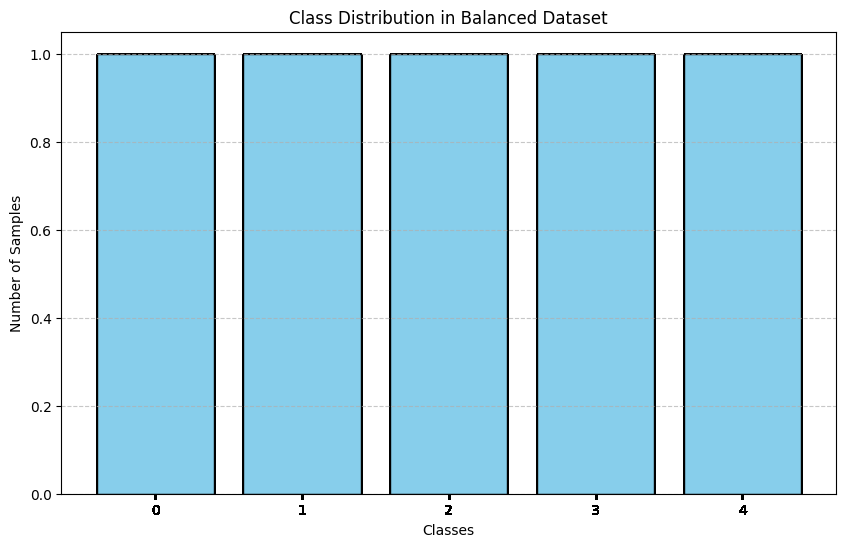

In [34]:
import matplotlib.pyplot as plt

# Prepare data for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Balanced Dataset")
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()
